# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Binary Classification Proof of Concept

## Libraries

In [1]:
#::GMG::Which libraries are there?
list.files(R.home('library'))

[1] "base"         "boot"         "class"        "cluster"      "codetools"   
 [6] "compiler"     "datasets"     "foreign"      "graphics"     "grDevices"   
[11] "grid"         "KernSmooth"   "lattice"      "MASS"         "Matrix"      
[16] "methods"      "mgcv"         "nlme"         "nnet"         "parallel"    
[21] "rpart"        "spatial"      "splines"      "stats"        "stats4"      
[26] "survival"     "tcltk"        "tools"        "translations" "utils"

**::GMG::** Original `stdout`:

```shell
     'base' 'boot' 'class' 'cluster' 'codetools' 'compiler' 'datasets' 'foreign' 'graphics' 'grDevices' 'grid' 'KernSmooth' 'lattice' 'MASS' 'Matrix' 'methods' 'mgcv' 'nlme' 'nnet' 'parallel' 'rpart' 'spatial' 'splines' 'stats' 'stats4' 'survival' 'tcltk' 'tools' 'translations' 'utils' 
```

In [2]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [3]:
#::GMG::I'm going to use ... 
# ... mlbench for getting pima indians dataset ...
# https://cran.r-project.org/web/packages/mlbench/index.html
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
# ... caTools for train/test splitting datasets ...
# https://cran.r-project.org/web/packages/caTools/index.html
# https://cran.r-project.org/web/packages/caTools/caTools.pdf
# ... correlation plot (corrplot) for EDA visualization ...
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://cran.r-project.org/web/packages/corrplot/index.html
using('mlbench', 'caTools', 'corrplot')

Loading required package: mlbench
Loading required package: caTools
Loading required package: corrplot
corrplot 0.84 loaded


## Dataset

### kaggle (downloaded)

In [4]:
#::GMG::Where am I?
# http://rfunction.com/archives/1042
getwd()

[1] "/home/jovyan/work/tfm/pub"

In [5]:
#::GMG::What's it there?
list.files()

[1] "data"                                           
 [2] "LICENSE"                                        
 [3] "model"                                          
 [4] "poc-class-pima-indians-diabetes.ipynb"          
 [5] "poc-class-r-pima-indians-diabetes.ipynb"        
 [6] "poc-class-tuning-pima-indians-diabetes.ipynb"   
 [7] "poc-fs-embed-pima-indians-diabetes.ipynb"       
 [8] "poc-fs-filter-pima-indians-diabetes.ipynb"      
 [9] "poc-fs-wrapper-pima-indians-diabetes.ipynb"     
[10] "poc-model-selection-pima-indians-diabetes.ipynb"
[11] "README.md"

In [6]:
#::GMG::I've already downloaded from kaggle using my account the csv dataset
#       that is located in the data folder
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/list.files.html
dir("data", pattern = "*.csv", full.names = TRUE, ignore.case = TRUE)

[1] "data/pima-indians-diabetes.csv"

In [7]:
#::GMG::Load the data into a data frame
pima <- read.csv('data/pima-indians-diabetes.csv')

In [8]:
head(pima)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [9]:
#::GMG::I try to get to know the R object
# https://swcarpentry.github.io/r-novice-inflammation/13-supp-data-structures/
#    class() - what kind of object is it (high-level)?
#    typeof() - what is the object’s data type (low-level)?
#    length() - how long is it? What about two dimensional objects?
#    attributes() - does it have any metadata?
# http://www.studytrails.com/r/core/r_print_format/
# http://www.studytrails.com/r/core/r_console_printing/
# https://www.rdocumentation.org/packages/R.utils/versions/2.8.0/topics/printf
# 
cat('pima class and type: ', class(pima), typeof(pima))

pima class and type:  data.frame list

**::NOTE::** Attributes:

```R
attributes(pima)

$names
   'Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age' 'Outcome' 

$class
   'data.frame'

$row.names
   1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41  ... 765 766 767 768
```

In [10]:
cat('pima shape (rows, cols): ', nrow(pima), ncol(pima))

pima shape (rows, cols):  768 9

In [11]:
cat('pima features: \n', 
    format(attributes(pima)$names, justify = "none"), 
    fill = 10
   )

pima features: 
 
Pregnancies 
Glucose 
BloodPressure 
SkinThickness 
Insulin 
BMI 
DiabetesPedigreeFunction 
Age 
Outcome


### mlbench (attached)

In [12]:
#::GMG::With mlbench there's an aalternative to get the pima indians diabetes dataset
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
data(PimaIndiansDiabetes)

In [13]:
head(PimaIndiansDiabetes)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,pos
1,85,66,29,0,26.6,0.351,31,neg
8,183,64,0,0,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,0,0,25.6,0.201,30,neg


In [14]:
#::GMG::There are two versions in mlbench (!)
#::NOTE::What is the difference?
data(PimaIndiansDiabetes2)

In [15]:
head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


## Exploratory Data Analysis

**::GMG::** The goal of this stage of our study is to get to know the data, their flaws and perhaps some clues to improve them.

### stats

In [16]:
#::GMG::Here I can see the variables (datasets and functions in memory)
ls()

[1] "pima"                 "PimaIndiansDiabetes"  "PimaIndiansDiabetes2"
[4] "using"

**::GMG::** This dataset consists of 768 observations of 9 variables: 8 variables which will be used as model predictors (number of times pregnant, plasma glucose concentration, diastolic blood pressure (mm Hg), triceps skin fold thickness (in mm), 2-hr serum insulin measure, body mass index, a diabetes pedigree function, and age) and 1 outcome variable (whether or not the patient has diabetes)

In [17]:
#::GMG::There are subtle differences between the kaggle and mlbench datasets
#       i.e. PimaIndiansDiabetes (say, v1) has the class as a factor (R compliant)
str(PimaIndiansDiabetes)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [18]:
summary(PimaIndiansDiabetes)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00            
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00            

**::GMG::** It's explained in the [mlbench documentation](https://cran.r-project.org/web/packages/mlbench/mlbench.pdf) (pp. 29):

> The data set `PimaIndiansDiabetes2` contains a corrected version of the original data set.  While the UCI repository index claims that there are no missing values, closer inspection of the data shows **several physical impossibilities**, e.g., blood pressure or body mass index of 0. In `PimaIndiansDiabetes2`, all *zero values* of glucose, pressure, triceps, insulin and mass have been **set to NA**.

In [19]:
#::GMG::PimaIndiansDiabetes2 (say, v2) has the outliers from 
#       glucose, pressure, triceps, insulin and mass as NAs
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [20]:
#::GMG::NA counts yield the outliers (!)
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [21]:
#::GMG::The kaggle version has different names for the features and class
#       Outcome is not a factor but a 'binary' integer type
#       Outliers (zeros in Glucose, BloodPressure, SkinThickness, Insulin and BMI) are kept
#       but not marked as NA
str(pima)

'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 0 1 1 ...


In [24]:
summary(pima)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    Insulin           BMI        DiabetesPedigreeFunction      Age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780           Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437           1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725           Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719           Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262           3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outcome  
 n

**::GMG::** Here I *notice* that the features are not commensurate with each other. That means some features may need (or may not) some sort of scaling or normalization depending on the [assumptions of the classificatiom method](https://www.statisticssolutions.com/assumptions-of-logistic-regression/) to be used. 

**::NOTE::** It would be useful to take a look at the wisdom of *stackexchange crossvalidated* about this: [Is standardization needed before fitting logistic regression?](https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression)

**::GMG::** I *also notice* there are zeros in features that *don't allow such a value*, for example `BlodPressure`, `BMI` or `SkinThickness`. These are flaws or *ouliers* and should be fixed. This is not always easy or strightforward and may require deep domain knowledge.

### missing values/outliers

**::GMG::** The Pima Indians Dataset have missing values (NAs) and/or *outliers* depending on the instance of dataset chosen (`kaggle` or `mlbench`). The outliers are zero values from features that cannot have such a value, i.e. `glucose` (`Glucose`), `pressure` (`BloodPressure`), `triceps` (`SkinThickness`), `insulin` (`Insulin`) and `mass` (`BMI`)  

In [25]:
#::GMG::Check for missing values ... I know they are marked witn 'NA' in mlbench 2nd dataset
sapply(PimaIndiansDiabetes2, function(x) sum(is.na(x)))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0

In [26]:
#::GMG::Check for missing values
#::NOTE::There's no 'NA' marking in kaggle dataset so I know the result beforehand
#        and the fact that physical impossible values in some features are not taken 
#        into account (!)
sapply(pima, function(x) sum(is.na(x)))

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

In [27]:
#::GMG::Counting 'Outliers' a.k.a "physical impossibilities" (Zeros)
# https://stackoverflow.com/questions/22286957/count-the-number-of-non-zero-elements-of-each-column
apply(X = pima[c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")], 
      MARGIN = 2, 
      FUN = function(c) sum(c == 0))

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

**::GMG::** I'll decide how to deal with the outliers in the pre-processing phase (after the train/test split to avoid *data snooping*)

### visualizations

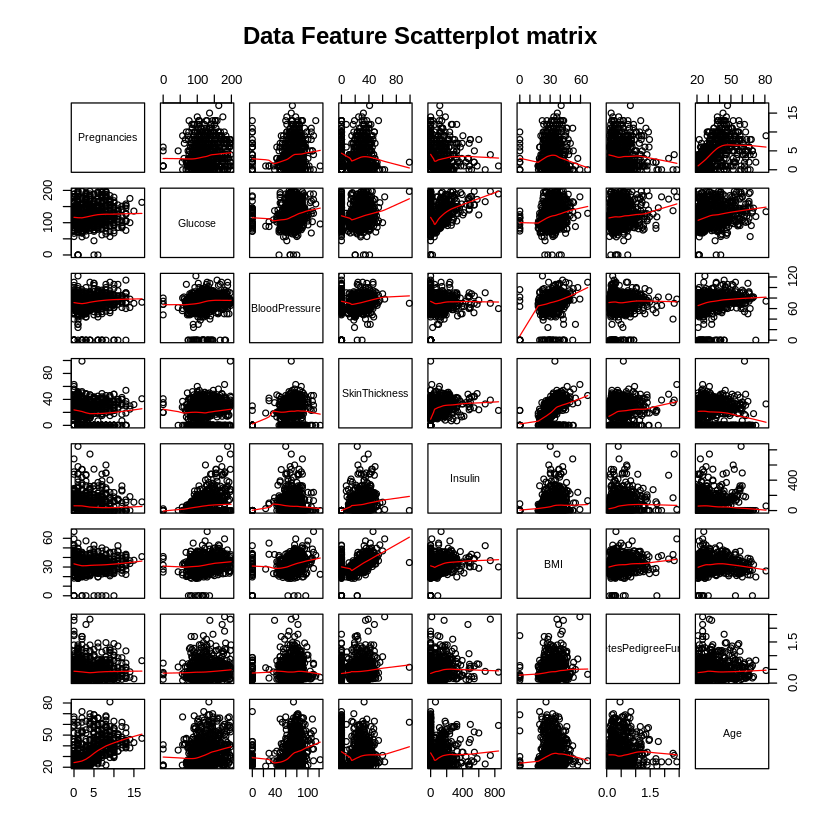

In [28]:
#::GMG::pair plot to see correlations between pairs of features
#::NOTE::See also:
# https://www.statmethods.net/advgraphs/trellis.html
# https://www.statmethods.net/graphs/scatterplot.html
# https://www.statmethods.net/advgraphs/layout.html
# https://www.r-bloggers.com/scatterplot-matrices-pair-plots-with-cdata-and-ggplot2/
pairs(pima[1:8], 
      pch = 21, 
      main = 'Data Feature Scatterplot matrix', 
      panel = panel.smooth
     )

In [29]:
#::GMG::Another way to see correlations with corrplot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cor.html
# https://www.statmethods.net/stats/correlations.html
#::NOTE::Se also https://www.statmethods.net/advgraphs/correlograms.html
M <- cor(pima)

ERROR: Error in cor(pima): 'x' must be numeric


In [ ]:
#::GMG::Plpot correlation plot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
col<- colorRampPalette(c("red", "white", "blue"))(20)
corrplot(M, method="number", type="upper", order="hclust", col = col)

**::GMG::** I could infer some naïve *redudance* and *importance* assessments from the pair correlation values between the features and between each feature and the target (`Outcome`) and take some decisions about dropping or keeping the features downstream in the model.

**NOTE** I think doing this before train/test split would be a major flaw in my dataflow resulting in *data snooping* and invalidating my final algorith metric computations. 

### note

In [22]:
#::GMG::I change the Outcome variable into a 2 factor, The R way ;)
# https://swcarpentry.github.io/r-novice-inflammation/12-supp-factors/
# https://www.stat.berkeley.edu/~s133/factors.html
# https://stackoverflow.com/questions/13613913/how-do-i-convert-certain-columns-of-a-data-frame-to-become-factors
pima$Outcome <- as.factor(x = pima$Outcome)
levels(pima$Outcome) <- c('neg', 'pos')

In [23]:
str(pima)

'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


### imbalance

**::GMG::** Finally I think It's worth noting that there is **imbalance** in the dataset. It's not an extreme imbalance but I'll take it into account in train/test splitting and the choice of metrics for method evaluation.

In [ ]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(pima$Outcome)

In [ ]:
prop.table(table(pima$Outcome))

In [ ]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
# https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=4, repr.plot.height=3)
barplot(100*prop.table(table(pima$Outcome)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Train/Test Split

In [ ]:
#::GMG::Let's make it reproducible
set.seed(1)

In [ ]:
#::GMG::I do the customary train/test split BUT stratifiying (?) because of the imbalance
#       to make sure the percentages of healthy/diabetes hold in the train and test sets
#
#::NOTE::caTools has sample.split( Y, SplitRatio = 2/3, group = NULL )
# https://www.rdocumentation.org/packages/caTools/versions/1.17.1/topics/sample.split
# https://cran.r-project.org/web/packages/caTools/caTools.pdf
#
# Split data from vector Y into two sets in predefined ratio while preserving relative ratios of 
# differentlabels in Y. Used to split the data used during classification into train and 
# test subsets.
#::NOTE::So it seems this does whay I want it to do ...
msk <- sample.split(Y = pima$Outcome, SplitRatio = 0.7)

In [ ]:
pima_train <- pima[msk,]  # use output of sample.split to ...
pima_test  <- pima[!msk,] # create train and test subse

In [ ]:
str(pima_train)

In [ ]:
prop.table(table(pima_train$Outcome))

In [ ]:
#::GMG::Plot the imbalance, see wether percentage is kept
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
barplot(100*prop.table(table(pima_train$Outcome)), 
        col = c('green', 'orange'),
        ylim = c(0,70),
        main = 'Train Outcome Imbalance')

In [ ]:
str(pima_test)

In [ ]:
prop.table(table(pima_test$Outcome))

In [ ]:
#::GMG::Plot the imbalance, see wether percentage is kept
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
barplot(100*prop.table(table(pima_test$Outcome)), 
        col = c('green', 'orange'),
        ylim = c(0,70),
        main = 'Test Outcome Imbalance')

## Pre-Processing

### outliers

In [25]:
#::GMG::What do I do with the outliers?
#       Glucose, Insulin, BloodPressure, SkinThickness, and BMI 
#       Options: remove, impute, leave them untouched (lto)
#       Chosen: remove (Glucose, BloodPressure, BMI) + lto (SkinThickness, Insulin)
# https://stackoverflow.com/questions/9977686/how-to-remove-rows-with-a-zero-value-in-r
#::NOTE::I cannot remove the outliers from SkinThickness and Insuline 
#        because they're a big slice of the dataset (!)
row_sub <- apply(
             X = pima[c("Glucose", "BloodPressure", "BMI")], 
             MARGIN = 1, 
             FUN = function(row) all(row != 0)
)

**::NOTE::** I've [searched](https://www.google.com/search?client=firefox-b-d&q=a+person+can+have+zero+insulin%3F) about this *zero insulin issue*. So [it turns out](https://www.yourhormones.info/hormones/insulin/) that:

> People with type 1 diabetes produce very little or no insulin at all. This condition is caused when the beta cells that make insulin have been destroyed by antibodies (these are usually substances released by the body to fight against infections), hence they are unable to produce insulin.

So it remains only the `SkinThickness` zero physical impossibility *unresolved* and left it be.

In [26]:
#::GMG::I remove some of the outliers
pima_mod <- pima[row_sub,]

In [27]:
#::GMG::The somewhat cleaned dataset ...
str(pima_mod)

'data.frame':	724 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 2 4 10 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 197 110 168 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 70 92 74 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 45 0 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 543 0 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 53 30 34 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 1 0 1 ...


In [31]:
#::GMG::Variables created so far :)
ls()

[1] "col"                  "M"                    "pima"                
[4] "pima_mod"             "PimaIndiansDiabetes"  "PimaIndiansDiabetes2"
[7] "row_sub"              "using"

In [33]:
str(pima_mod)

'data.frame':	724 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 2 4 10 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 197 110 168 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 70 92 74 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 45 0 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 543 0 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 53 30 34 ...
 $ Outcome                 : Factor w/ 2 levels "healthy","diabetes": 2 1 2 1 2 1 2 2 1 2 ...


## logistic regression (logit)

### fit and predict

In [49]:
#::GMG::Training The Model
# https://www.statmethods.net/advstats/glm.html
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/glm
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/glm.html
#::NOTE:there's a parameter called weights:
#       an optional vector of ‘prior weights’ to be used in the fitting process. Should be NULL or a numeric vector.
#
#       In the details sections from documentation:
#       Non-NULL weights can be used to indicate that different observations have different dispersions 
#       (with the values in weights being inversely proportional to the dispersions); or equivalently, 
#       when the elements of weights are positive integers w_i, that each response y_i is the mean of w_i 
#       unit-weight observations. For a binomial GLM prior weights are used to give the number of trials 
#       when the response is the proportion of successes: they would rarely be used for a Poisson GLM.
#
#::QUESTION::Is this the same as in scikit learn 'balanced' model parameter?
fit_pima <- glm(Outcome ~., 
                data = pima_train, 
                family = binomial(link = 'logit'))

In [50]:
#::GMG::Model results
summary(fit_pima)


Call:
glm(formula = Outcome ~ ., family = binomial(link = "logit"), 
    data = pima_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3973  -0.7262  -0.4233   0.7181   2.1822  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -8.443753   0.951340  -8.876  < 2e-16 ***
Pregnancies               0.118361   0.038937   3.040  0.00237 ** 
Glucose                   0.036429   0.004530   8.041 8.93e-16 ***
BloodPressure            -0.011207   0.009749  -1.149  0.25035    
SkinThickness             0.004841   0.008393   0.577  0.56413    
Insulin                  -0.001395   0.001062  -1.314  0.18894    
BMI                       0.082632   0.019409   4.258 2.07e-05 ***
DiabetesPedigreeFunction  0.646150   0.353523   1.828  0.06759 .  
Age                       0.013788   0.011513   1.198  0.23104    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial famil

**::GMG::** The result shows that the variables `BloodPressure`, `SkinThickness`, `Insulin`, `Diabetes PedigreeFunction` and `Age` are *not statiscally significant*. In other words, the *p_values is greather than 0.05*. Therefore they will be removed.

In [57]:
fit_pima2 <- update(
    fit_pima, ~. - BloodPressure - SkinThickness - Insulin  - Age 
)

In [58]:
#::QUESTION::How do I interpret the model: null/residual deviance, AIC?
summary(fit_pima2)


Call:
glm(formula = Outcome ~ Pregnancies + Glucose + BMI + DiabetesPedigreeFunction, 
    family = binomial(link = "logit"), data = pima_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5359  -0.7300  -0.4197   0.7192   2.1482  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -8.441249   0.818037 -10.319  < 2e-16 ***
Pregnancies               0.138123   0.033293   4.149 3.34e-05 ***
Glucose                   0.034875   0.004062   8.585  < 2e-16 ***
BMI                       0.075587   0.017175   4.401 1.08e-05 ***
DiabetesPedigreeFunction  0.609202   0.346186   1.760   0.0784 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 651.29  on 505  degrees of freedom
Residual deviance: 484.03  on 501  degrees of freedom
AIC: 494.03

Number of Fisher Scoring iterations: 4


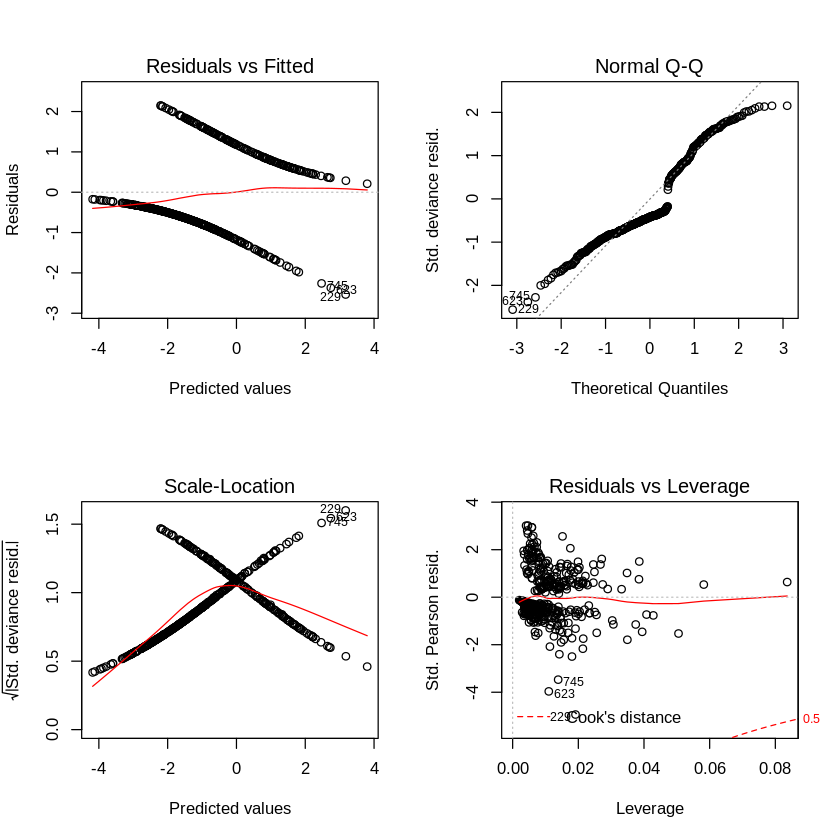

In [59]:
#::QUESTION::How do I interpret the model graphs: Q-Q and the rest?
par(mfrow = c(2,2))
plot(fit_pima2)

In [60]:
#::GMG::95% CI for the coefficients
confint(fit_pima2) 

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-10.11487956,-6.90148579
Pregnancies,0.07359045,0.20439387
Glucose,0.02716364,0.04312258
BMI,0.04259290,0.11009657
DiabetesPedigreeFunction,-0.05983122,1.30026476


In [156]:
#::GMG:: predicted values as probabilities (not yet classes)
prob <- predict(fit_pima2, newdata = pima_test, type="response") 

In [202]:
str(prob)

 Named num [1:218] 0.0425 0.0486 0.1614 0.0567 0.8806 ...
 - attr(*, "names")= chr [1:218] "2" "4" "6" "7" ...


In [150]:
#::GMG:: predicted classes with 0.5 prob cutoff value (that may not be the optimal (?))
pima_pred <- ifelse(test = prob > 0.5, yes = 1, no = 0)

In [125]:
pima_pred <- as.factor(pima_pred)
levels(pima_pred) <- c('healthy', 'diabetes')
str(pima_pred)

 Factor w/ 2 levels "healthy","diabetes": 1 1 1 1 2 2 1 1 2 1 ...
 - attr(*, "names")= chr [1:218] "2" "4" "6" "7" ...


### evaluation

In [142]:
#::GMG::Confusion Matrix AND metrics
# cm <- table(Predicted = pima_pred, Actual = pima_test$Outcome)
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/table
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
# https://stackoverflow.com/questions/33621592/sum-of-antidiagonal-of-a-matrix
# https://stackoverflow.com/questions/14577412/how-to-convert-variable-object-name-into-string
confusion_matrix <- function (true, pred, beta = 1) {
    t <- table(true, pred)
    p <- t[2,2]/sum(t[,2])
    r <- t[2,2]/sum(t[2,])
    s <- t[1,1]/sum(t[1,])
    list(cm = t,
         accuracy = sum(diag(t))/sum(t), 
         #error_rate = sum(diag(t[nrow(t):1,]))/sum(t),
         precision = p, 
         recall = r, #::NOTE::it's also called sensitivity
         f1 = (1 + beta^2) * p * r/((beta^2 * p) + r),
         specificity = s,
         prevalence = sum(t[2,])/sum(t),
         balanced_accuracy = (r + s) / 2
        )
}

In [151]:
#::GMG::Get confusion matrix and metrics
cf <- confusion_matrix(true = pima_test$Outcome, pred = pima_pred)

In [152]:
#::GMG::Print 'raw' confusion matrix
cf$cm

          pred
true         0   1
  healthy  131  12
  diabetes  33  42

In [153]:
#::GMG::Mterics
# https://stackoverflow.com/questions/3443687/formatting-decimal-places-in-r
cat(sep='', "Accuracy: ", format(round(cf$accuracy, 2), nsmall = 2), 
    ", Balanced Accuracy ", format(round(cf$balanced_accuracy, 2), nsmall = 2))

Accuracy: 0.79, Balanced Accuracy 0.74

In [154]:
cat(sep = '', "Precision: ", format(round(cf$precision, 2), nsmall = 2), 
    ", Recall: ", format(round(cf$recall, 2), nsmall = 2),
    ", Fl: ", format(round(cf$f1, 2), nsmall = 2)
   )

Precision: 0.78, Recall: 0.56, Fl: 0.65

In [179]:
cat(sep='', "Specificity: ", format(round(cf$specificity, 2), nsmall = 2), 
    ", Sensitivity ", format(round(cf$recall, 2), nsmall = 2))

Specificity: 0.92, Sensitivity 0.56

In [181]:
# https://cran.r-project.org/web/packages/PRROC/index.html
using('PRROC')

Loading required package: PRROC
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘PRROC’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: PRROC


[[1]]
[1] TRUE

**::GMG::** First time run (instalation) 

```R
Loading required package: PRROC

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :

“there is no package called ‘PRROC’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Loading required package: PRROC

    TRUE
```

In [272]:
#::GMG::Precision Recall Curve and PR AUC
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0092209
# https://stats.stackexchange.com/questions/10501/calculating-aupr-in-r
#::NOTE::scores.class0 - the classification scores of all data points
#        scores.class1 should not be assigned an explicit value, but left
#        at the default (scores.class1=scores.class0). In addition, weights.class0 needs to
#        contain the class labels of the data points (1 for positive class, 0 for negative
#        class) or **the soft-labels for the positive class, i.e., the probability for each data
#        point to belong to the positive class**. Accordingly, weights.class1 should be left
#        at the default value (1-weights.class0).
# ** This DOES NOT work for me! 8-()
# If weights.class0 = prob(pima_test$Outcome == "diabetes") ... Is this soft-labels?
# then **Error in if (sum(weights < 0) != 0) {: missing value where TRUE/FALSE needed**
pr_1 <- pr.curve(scores.class0 = prob,
                 weights.class0 = pima_test$Outcome == "diabetes",
                 min.compute = T, 
                 max.compute = T,
                 rand.compute = T,
                 curve = T)

In [273]:
print(pr_1)


  Precision-recall curve

    Area under curve (Integral):
     0.7734331 

    Relative area under curve (Integral):
     0.7181818 

    Area under curve (Davis & Goadrich):
     0.7734053 

    Relative area under curves (Davis & Goadrich):
     0.7181487 

    Curve for scores from  0.01255039  to  0.949035 
    ( can be plotted with plot(x) )



    Maximum AUC:
     1   1 


    Minimum AUC:
     0.1960532   0.1960487 


    AUC of a random classifier:
     0.3440367   0.3440367 


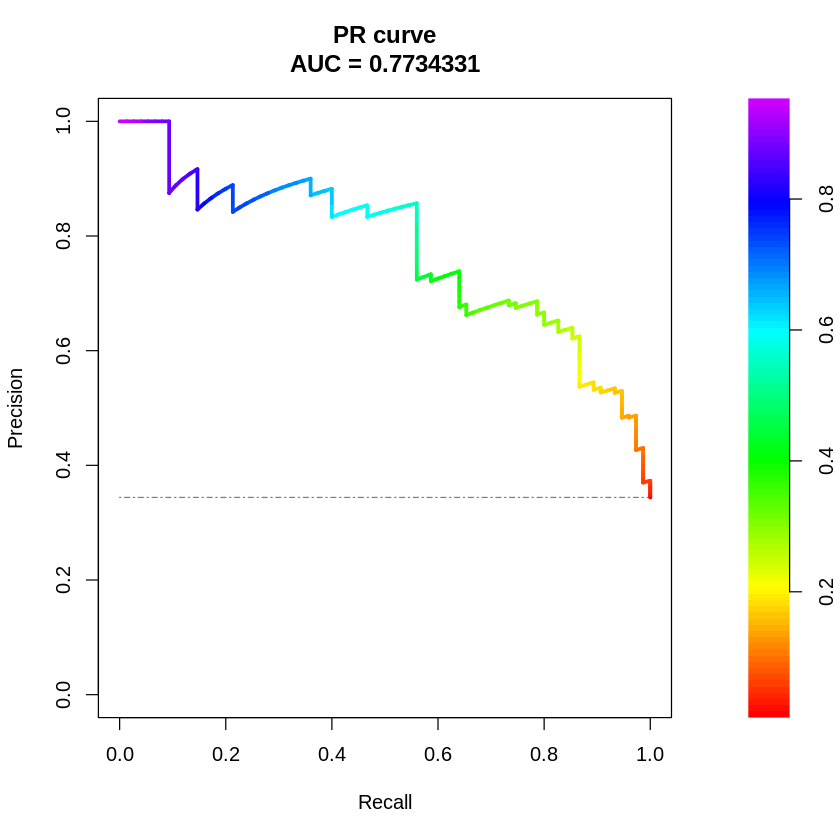

In [274]:
plot(pr_1, rand.plot = T)

In [275]:
#::GMG::Weights computations? I'm not sure ... It doesn't work properly
#       See ::NOTE in pr.curve cell (!)
weights <- ifelse(pima_test$Outcome == "healthy",
                        0.5*length(pima_test$Outcome)/table(pima_test$Outcome)[1] ,
                        0.5*length(pima_test$Outcome)/table(pima_test$Outcome)[2]
                 )

In [276]:
str(weights)

 num [1:218] 0.762 0.762 0.762 1.453 1.453 ...


In [278]:
#::GMG:: scores.class0 - the classification scores of only the data points belonging to the positive class.
#        the scores for the negative data points need to be provided in scores.class1. 
#        In this case, weights.class0 and weights.class1 need to be provided only for soft-labelling and 
#        should be of **the same length** as scores.class0 and scores.class1, respectively.
#
#        **so they are! BUT ...
pr_2 <- pr.curve(scores.class0 = prob[pima_test$Outcome == "diabetes"], #::GMG::'Positive' class
                 scores.class1 = prob[pima_test$Outcome == "healthy"], 
                 #::NOTE::If I try the weights it yields a warning message:
                 #
                 # Warning message in weights.class0 + weights.class1:
                 # “longer object length is not a multiple of shorter object length”
                 #
                 weights.class0 = weights[pima_test$Outcome == "diabetes"],
                 weights.class1 = weights[pima_test$Outcome == "healthy"],
                 min.compute = F, 
                 max.compute = F,
                 rand.compute = T,
                 curve = T)

Warning message in weights.class0 + weights.class1:
“longer object length is not a multiple of shorter object length”

In [279]:
print(pr_2)


  Precision-recall curve

    Area under curve (Integral):
     0.858406 

    Area under curve (Davis & Goadrich):
    cannot be computed for weighted data

    Curve for scores from  0.01255039  to  0.949035 
    ( can be plotted with plot(x) )



    AUC of a random classifier:
     0.3440367   0.3440367 


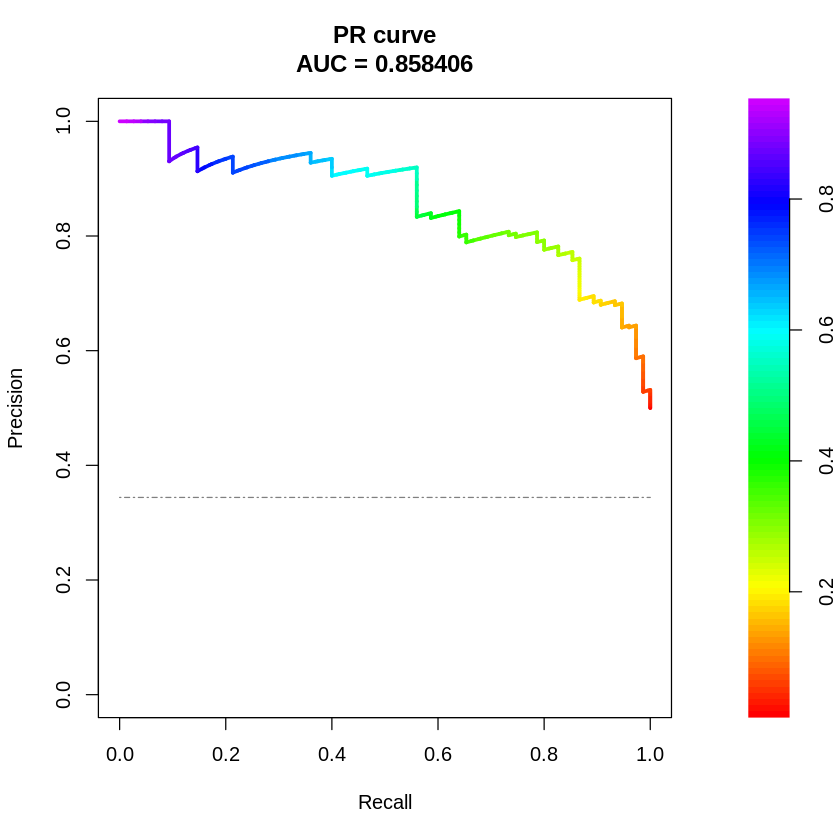

In [280]:
plot(pr_2, rand.plot = T)